In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
from kornia.morphology import gradient
from torchvision.utils import make_grid
from vitRet.data.fundus import EyePACSDataModule
from vitRet.models.model_factory import load_weights_from_timm
from vitRet.models.stochastic_attention.stochastic_vit import StochasticVisionTransformer


In [76]:
data_dir = '/usagers/clpla/data/eyepacs/'
img_size = (1024, 1024)
scales = 1
datamodule = EyePACSDataModule(data_dir, img_size=img_size, batch_size=1, num_workers=8, superpixels_scales=scales, 
                               superpixels_max_nb=8000,
                               superpixels_min_nb=1024)
datamodule.setup('fit')
datamodule.setup('test')


7097


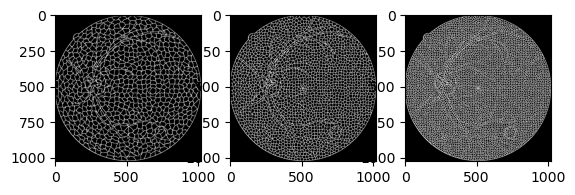

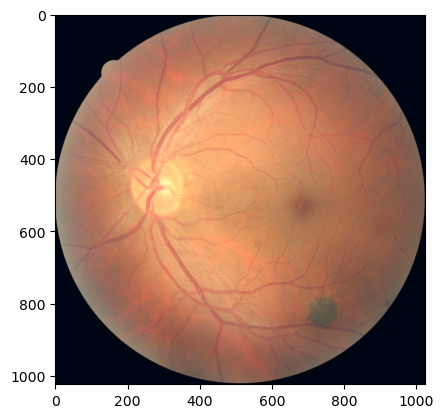

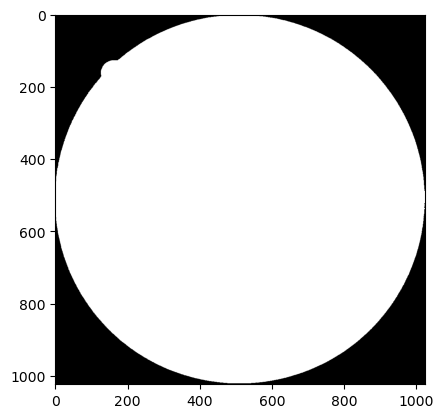

In [77]:
def plot_segments(segments, gradients=True):
    print(len(torch.unique(segments)))
    if segments.ndim==3:
        segments.unsqueeze_(0)
    if gradients:
        kernel = torch.ones(3,3)
        segments = gradient(segments, kernel=kernel)>0
    if segments.ndim==4:
        segments.squeeze_(0)
    n_segments = segments.shape[0]
    fig, axs = plt.subplots(1, n_segments)
    if n_segments==1:
        axs = [axs]
    for ax, seg in zip(axs, segments):
        ax.imshow(seg)
    plt.show()
dataset = datamodule.train
index = 10
batch = dataset[index]
plot_segments(batch['segments'])
img = batch['image'].permute(1,2,0).numpy()
img = (img-img.min())/(img.max()-img.min())
plt.imshow(img)
plt.show()
plt.imshow(batch['mask'])
plt.show()

In [78]:
batch['segments'].max()

tensor(7960)

In [79]:
import torch
ckpt_path = '/usagers/clpla/Experimentations/RetinalViT/checkpoints/usual-dream-229/epoch=42-step=27907.ckpt'


model = StochasticVisionTransformer(num_classes=1, 
                                    scales=scales,
                                    img_size=img_size, 
                                    kernel_size=16,
                                    qkv_bias=True, drop_path=0.2,
                                    global_pool=False,
                                    projection_stride=4)

state_dict = torch.load(ckpt_path, map_location='cpu')['state_dict']
for k in list(state_dict.keys()):
    state_dict[k.replace('model.', '')] = state_dict.pop(k)
state_dict['tokenizer.cls_pos_embed'].unsqueeze_(1)
model.load_state_dict(state_dict=state_dict, strict=True)

<All keys matched successfully>

In [80]:
dataloader = datamodule.test_dataloader()
indices,  = np.where(dataloader.dataset.gts['label']==3)
dataloader.dataset.subset(indices)
iterdata = iter(dataloader)
_ = next(iterdata)


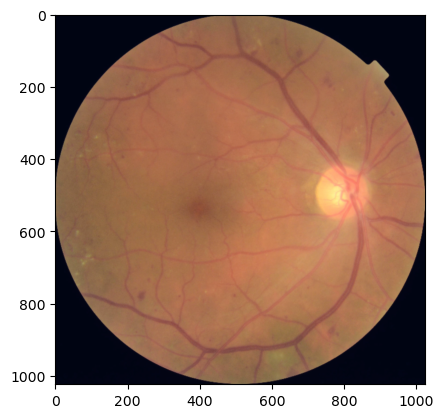

tensor(3.) tensor([3])


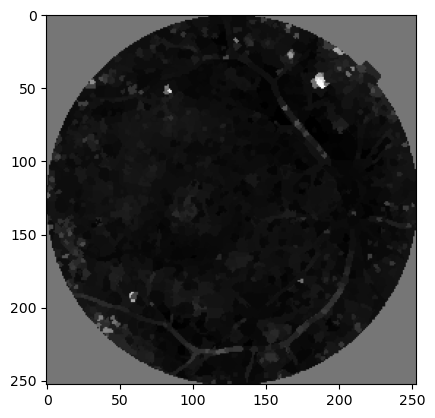

In [84]:
batch = next(iterdata)
model.eval()


with torch.no_grad():
    pred, attn = model(batch['image'], batch['segments'], True)

images_grid = make_grid(batch['image'], normalize=True)
attn_grid = make_grid(attn.unsqueeze(1), normalize=True)
plt.imshow(images_grid.permute(1, 2, 0))
plt.show()
print(torch.clamp(torch.round(pred), 0, 5).squeeze(), batch['label'])
plt.imshow(attn_grid.permute(1, 2, 0))
plt.show()
